# NLP (Natural Language Processing) Disaster Tweets

This Kaggle competition is about classifying texts. It is an excellent introduction to Natural Language Processing (NLP). 

Original Competition and Data source: https://www.kaggle.com/c/nlp-getting-started/overview

Github: https://github.com/GHeart01/NLP-Disaster-Tweets

A screenshot of your position on the Kaggle competition leaderboard for your top-performing model.

### Table of Contents
- [Description](#Description)
- [EDA](#Exploratory-Data-Analysis-Procedure)
- [Model Architecture](#Model-Architecture)
- [Results and Analysis](#Results-and-Analysis)
- [Hypertuning](@Hypertuning)
- [Conclusion](#Conclusion)
- [Citation](#Citation)

### Description



This Kaggle Competition focuses on Natural Language Processing (NLP) using Disaster Tweets. The challange here is predicting which tweets are about real disasters and which are not. Here we have a binary classification where 1 is real and 0 is not real.The goal in this competition is to automatically distinguish between tweets that describe actual disasters, and tweets that use words like "ABLAZE" in a metaphorical or humorous sense. 

I will analyze the data using NLP and produce an output csv file to compare against the correct values to determine the strength of my NLP.


### Exploratory Data Analysis Procedure

From the Kaggle Description I created this table

| Column    | Description                                      | Data Type     | Missing Values | Notes                                                             |
|-----------|--------------------------------------------------|---------------|----------------|-------------------------------------------------------------------|
| `id`      | Unique identifier for each tweet                 | Integer       | None           | Primary key; not useful for modeling directly                    |
| `text`    | The content of the tweet                         | String (Text) | None           | Main feature for NLP tasks; requires preprocessing (e.g. clean, tokenize) |
| `location`| Location tweet was sent from                     | String        | Many missing   | Optional feature; can be engineered (e.g. country, city)         |
| `keyword` | Disaster-related keyword in tweet                | String        | Many missing   | Categorical; useful for topic-related features                   |
| `target`  | 1 if tweet is about a real disaster, else 0      | Integer (0/1) | Not in test set| Binary classification target variable (only in `train.csv`)      |

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'


In [2]:
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# check if import wored
# print("TensorFlow version:", tf.__version__)
# print("KerasNLP version:", keras_nlp.__version__)

2025-07-26 20:40:24.657392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753562424.843825      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753562424.903161      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


In [3]:
#import the data
train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

Brief description of the problem and data (5 pts)

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

Model Architecture (25 pts)

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

Results and Analysis (35 pts)

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.


Conclusion (15 pts)

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?



In [4]:
#quick test to confirm import data worked, also get a look at the data
print("\n Train Head")
print(train_data.head().to_string(index=False)) # ensure entire row on one terminal line

print("\n Train Tail")
print(train_data.tail().to_string(index=False))

print("\n Test Head")
print(test_data.head().to_string(index=False))

print("\n Test Tail")
print(test_data.tail().to_string(index=False))

print("\n Train size")
print(train_data.size)

print("\n Test size")
print(test_data.size)

print()
print('Training Set Shape = {}'.format(train_data.shape))
print('Training Set Shape = {}'.format(test_data.shape))




 Train Head
 id keyword location                                                                                                                                  text  target
  1     NaN      NaN                                                                 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all       1
  4     NaN      NaN                                                                                                Forest fire near La Ronge Sask. Canada       1
  5     NaN      NaN All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected       1
  6     NaN      NaN                                                                     13,000 people receive #wildfires evacuation orders in California        1
  7     NaN      NaN                                              Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school        1

 Train T

In [5]:
# quick stats
train_data["length"] = train_data["text"].apply(lambda x : len(x))
test_data["length"] = test_data["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(train_data["length"].describe())
print()

print("Test Length Stat")
print(test_data["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


From this quick look we can see 10874 data rows for our train data and 10875 for our test data, from the head and tail we can see there are many missing data points in location and keyword columns.

### Graphs and Visualizations

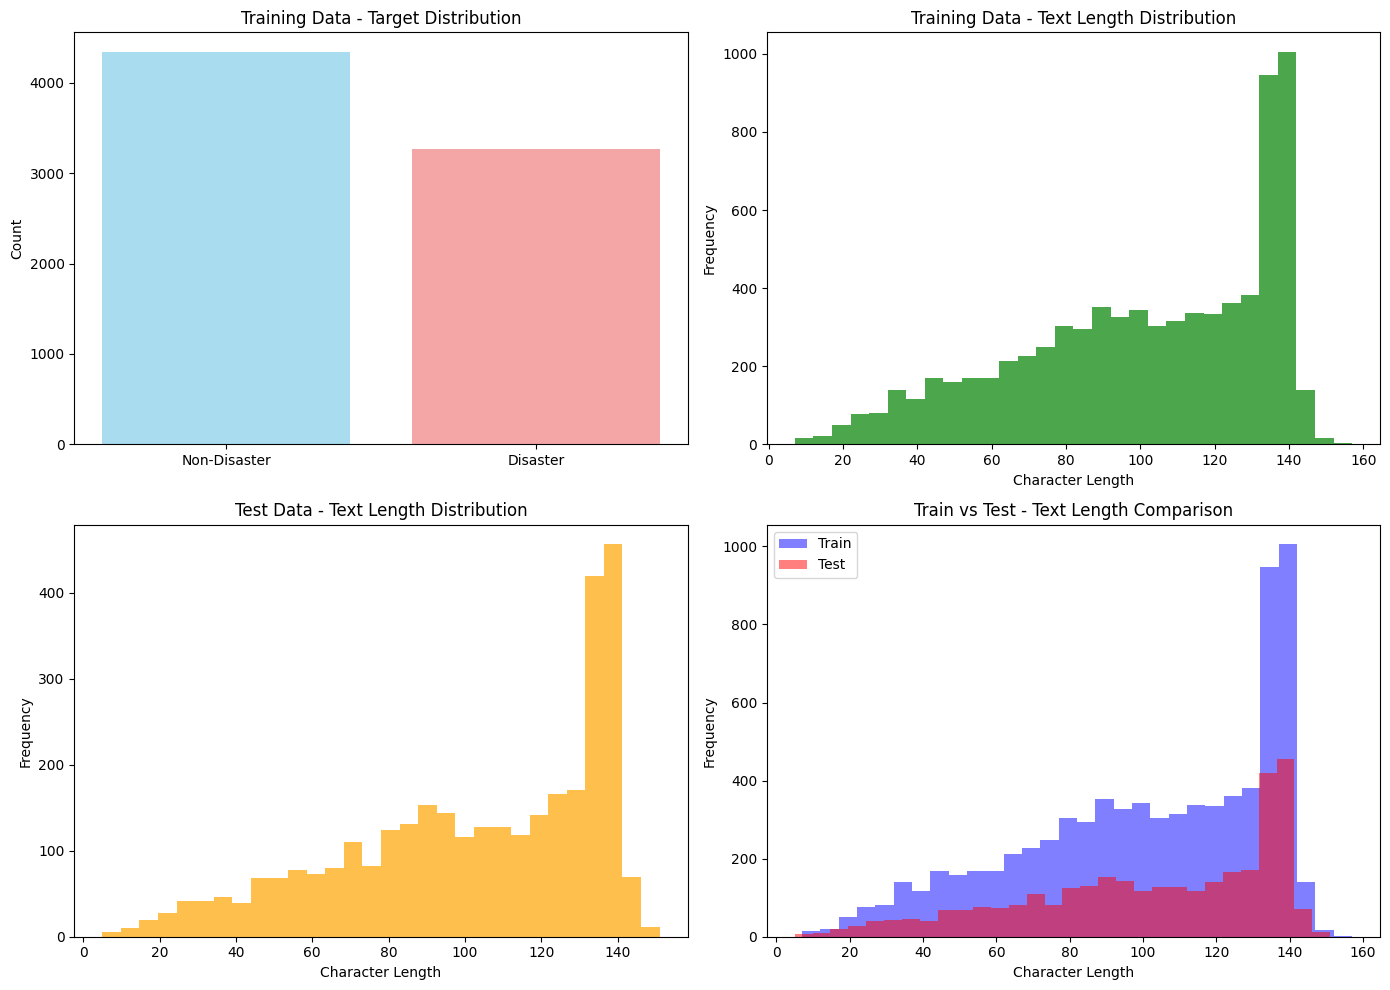

In [6]:
# HISTOGRAMS
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

train_data['text_length'] = train_data['text'].str.len()
test_data['text_length'] = test_data['text'].str.len()

# Train data - Target distribution
target_counts = train_data['target'].value_counts()
axes[0, 0].bar(['Non-Disaster', 'Disaster'], [target_counts[0], target_counts[1]], 
              color=['skyblue', 'lightcoral'], alpha=0.7)
axes[0, 0].set_title('Training Data - Target Distribution')
axes[0, 0].set_ylabel('Count')

# Train data - Text length histogram
axes[0, 1].hist(train_data['text_length'], bins=30, alpha=0.7, color='green')
axes[0, 1].set_title('Training Data - Text Length Distribution')
axes[0, 1].set_xlabel('Character Length')
axes[0, 1].set_ylabel('Frequency')

# Test data - Text length histogram
axes[1, 0].hist(test_data['text_length'], bins=30, alpha=0.7, color='orange')
axes[1, 0].set_title('Test Data - Text Length Distribution')
axes[1, 0].set_xlabel('Character Length')
axes[1, 0].set_ylabel('Frequency')

# Comparison of text lengths
axes[1, 1].hist(train_data['text_length'], bins=30, alpha=0.5, label='Train', color='blue')
axes[1, 1].hist(test_data['text_length'], bins=30, alpha=0.5, label='Test', color='red')
axes[1, 1].set_title('Train vs Test - Text Length Comparison')
axes[1, 1].set_xlabel('Character Length')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()



/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


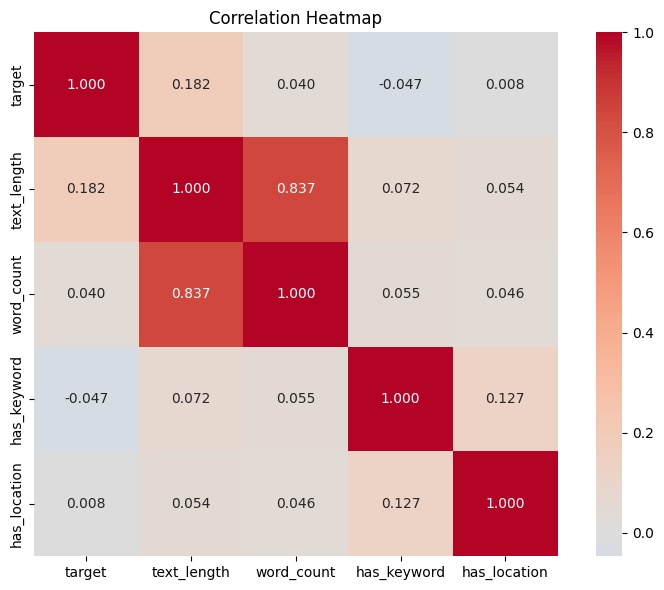

Dataset Overview:
Training data shape: (7613, 7)
Test data shape: (3263, 6)

Target distribution in training data:
Non-disaster tweets: 4342 (57.0%)
Disaster tweets: 3271 (43.0%)

Average text length:
Training data: 101.0 characters
Test data: 102.1 characters


In [7]:
# CORRELATION HEATMAP
# Create basic features for correlation
train_corr = train_data.copy()
train_corr['has_keyword'] = (~train_data['keyword'].isnull()).astype(int)
train_corr['has_location'] = (~train_data['location'].isnull()).astype(int)
train_corr['word_count'] = train_data['text'].str.split().str.len()

# Select only numeric columns for correlation
numeric_cols = ['target', 'text_length', 'word_count', 'has_keyword', 'has_location']
correlation_matrix = train_corr[numeric_cols].corr()

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Print basic statistics
print("Dataset Overview:")
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"\nTarget distribution in training data:")
print(f"Non-disaster tweets: {target_counts[0]} ({target_counts[0]/len(train_data)*100:.1f}%)")
print(f"Disaster tweets: {target_counts[1]} ({target_counts[1]/len(train_data)*100:.1f}%)")
print(f"\nAverage text length:")
print(f"Training data: {train_data['text_length'].mean():.1f} characters")
print(f"Test data: {test_data['text_length'].mean():.1f} characters")

Based on the EDA we can see the target distribution is in favor of non-disaster tweets, most tweets are between 100-145 words in length, and test and training sets have similar length distributions. My plan here is to first apply a model on the data, then perform some hypertuning to see if I can reach a reasonable success rate of classification, else I will perform data cleaning.

### Preprossing Data

In [8]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = train_data.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

Next I'll split the data

In [9]:
from sklearn.model_selection import train_test_split

X = train_data["text"]
y = train_data["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = test_data["text"]

### Model Architecture

### Set up DistilBERT model from Reference Tutorial on Kaggle

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.

The BertClassifier model can be configured with a preprocessor layer, in which case it will automatically apply preprocessing to raw inputs during fit(), predict(), and evaluate(). This is done by default when creating the model with from_preset().

We will choose DistilBERT model.that learns a distilled (approximate) version of BERT, retaining 97% performance but using only half the number of parameters.

It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

Specifically, it doesn't have token-type embeddings, pooler and retains only half of the layers from Google's BERT.

In [10]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()

I0000 00:00:1753562444.018069      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

### Results and Analysis

From the DistilBERT Model we can see with 66,955,010 parameters (all of which are trainable) we should have extensive Natural language understanding. With 66,362,880 of our 66,955,010 parameters we can see high fidelity in determining disaster tweets. We have extreemly high overfitting risk here as we have 67 million parameters and only about 7600 training samples, learning rate will likely be an important hyperparameter to tune.

### Hypertuning

Here I attempt to tackle the overfitting issue by adjusting learning rate with my own BERT model.

In [11]:
# Compile
from tensorflow import keras  # instead of `import keras`

classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(1e-5),
    metrics=["accuracy"]
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2


I0000 00:00:1753562476.065095      60 service.cc:148] XLA service 0x7ae994014410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753562476.065695      60 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753562478.441043      60 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753562492.381970      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


191/191 ━━━━━━━━━━━━━━━━━━━━ 112s 368ms/step - accuracy: 0.7102 - loss: 0.5659 - val_accuracy: 0.8444 - val_loss: 0.3948
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 51s 267ms/step - accuracy: 0.8425 - loss: 0.3732 - val_accuracy: 0.8457 - val_loss: 0.3821


In [12]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step


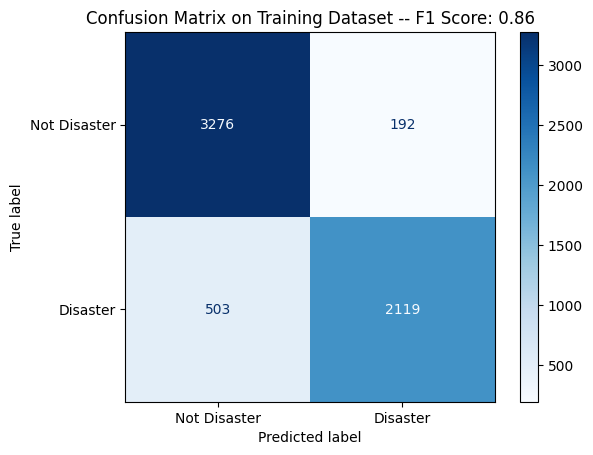

In [13]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step


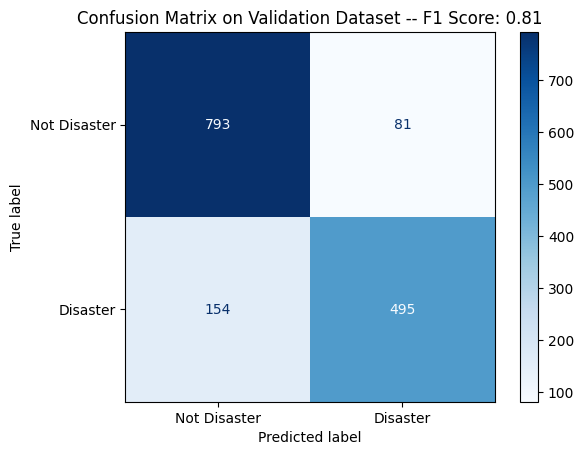

In [14]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

### Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

From the confusion matrixes on the custom BERT model, I was expecting something close to 80% accuracy against Kaggle data, but after submitting I achieved close to 83%. I did have to limit my model building here as the time to train was simply very long, but we get some explosure to using NLP models in the kaggle project. In the future, it would be interesting to try different learning rates and different epoch with muliple NLP models including ones other than BERT. With the differences in learning rate, performance increased from about 61% to 83% accuracy.

### Submission File

As stated in the problem Decription we need to make a submission file to compare against the correct values.

In [15]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)
sample_submission.describe()
sample_submission.to_csv("submission.csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step


### Citation

Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. Natural Language Processing with Disaster Tweets. https://kaggle.com/competitions/nlp-getting-started, 2019. Kaggle.

https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets #Reference tutorial